In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('../../data/kosdaq/price.csv', index_col = 'date', parse_dates = True)
sn = pd.read_csv("../../data/kosdaq/share_number.csv", index_col = 'date', parse_dates = True)
pm = pd.read_csv("../../data/kosdaq/price_mod.csv", index_col = 'date', parse_dates = True)

In [3]:
# 시가총액
market_cap = df * sn
market_cap.index = market_cap.index + pd.tseries.offsets.MonthEnd(0)
m_cap_k = market_cap.groupby('date').last()

# 월간 수익률
pm.index = pm.index + pd.tseries.offsets.MonthEnd(0)
m_pm = pm.groupby('date').last()
m_ret_k = (m_pm.fillna(-1) / m_pm.shift(1)).clip(0, 10) - 1

In [15]:
# dataframe.rank() 시간 단축하는 함수
def fast_rank(df: pd.DataFrame, axis=1, pct=True, ascending=True) -> pd.DataFrame:
    arr = df.values.copy()
    if not ascending:
        arr = -arr
    nan_mask = np.isnan(arr)
    # argsort 2번하면 rank를 값으로 갖게 됨
    # [70, 50, 60, nan] -> [1, 2, 0, 3] -> [2, 0, 1, 3]
    rank = arr.argsort(axis=axis).argsort(axis=axis)
    rank = rank.astype(float)
    
    # 1을 더해줌
    rank += np.ones(rank.shape)
    rank[nan_mask] = np.nan
    # np.nanmax : nan을 0으로 치환하고 max값 구함
    if pct:
        rank = rank / np.nanmax(rank, axis=axis)[:, np.newaxis]
    return pd.DataFrame(rank, index=df.index, columns=df.columns)

def get_momentum(m_ret, m_cap):
    # 전년도 월별 수익률 momentum 계산 (최근 1개월은 제외, 장기 모멘텀만 고려)
    momentum = (m_cap / m_cap.shift(12) - m_cap / m_cap.shift(1))

    # 시계열: winner - momentum 양수, loser - momentum 음수
    win_mask = momentum > 0
    lose_mask = momentum < 0 

    # 횡단면: momentum 큰 순서대로 분위별 포트폴리오 구성
    m_rank = fast_rank(momentum, axis = 1, pct = True, ascending=False)

    p1_mask = m_rank <= 0.2
    p2_mask = (m_rank > 0.2) & (m_rank <= 0.4)
    p3_mask = (m_rank > 0.4) & (m_rank <= 0.6)
    p4_mask = (m_rank > 0.6) & (m_rank <= 0.8)
    p5_mask = (m_rank > 0.8) & (m_rank <= 1.0)

    # 듀얼: winner - momentum 양수 중 상위 30%, loser - momentum 음수 중 하위 30%
    win_rank = fast_rank(momentum[win_mask], axis=1, pct=True, ascending=False)
    win_dual_mask = win_rank < 0.3
    lose_rank = fast_rank(momentum[lose_mask], axis = 1, pct = True, ascending=False)
    lose_dual_mask = lose_rank > 0.7

    # 시가총액 가중평균
    ts_cap_weight = [(m_cap[i].T / m_cap[i].sum(axis = 1)).T for i in [win_mask, lose_mask]]
    cs_cap_weight = [(m_cap[i].T / m_cap[i].sum(axis = 1)).T for i in [p1_mask, p2_mask, p3_mask, p4_mask, p5_mask]]
    dual_cap_weight = [(m_cap[i].T / m_cap[i].sum(axis = 1)).T for i in [win_dual_mask, lose_dual_mask]]
    
    return ts_cap_weight, cs_cap_weight, dual_cap_weight

def plot_momentum(m_ret, weights, ax):        
    # 시계열 plot
    ts_cr = [((m_ret * i.shift(1)).sum(axis = 1) + 1).cumprod()[11:] for i in weights[0]]
    sns.lineplot(ts_cr[0].index, ts_cr[0], label = 'winner', ax=ax[0])
    sns.lineplot(ts_cr[1].index, ts_cr[1], label = 'loser', ax=ax[0])
    ax[0].set(title=f'ts')
    
    # 횡단면 plot
    cs_cr = [((m_ret * i.shift(1)).sum(axis = 1) + 1).cumprod()[11:] for i in weights[1]]
    for i, j in zip(cs_cr, ['p1', 'p2', 'p3', 'p4', 'p5']):
        sns.lineplot(i.index, i, label = j, ax=ax[1])
    ax[1].set(title=f'cs')
    
    # dual plot
    dual_cr = [((m_ret * i.shift(1)).sum(axis = 1) + 1).cumprod()[11:] for i in weights[2]]
    sns.lineplot(dual_cr[0].index, dual_cr[0], label = 'winner', ax=ax[2])
    sns.lineplot(dual_cr[1].index, dual_cr[1], label = 'loser', ax=ax[2])
    ax[2].set(title=f'dual')

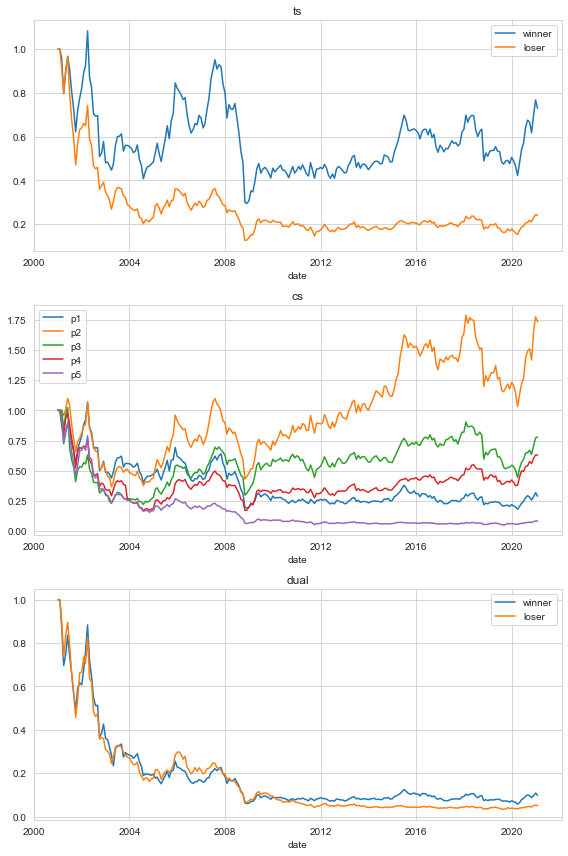

In [16]:
k_mo = get_momentum(m_ret_k, m_cap_k)

# left - korea, right - america
sns.set_style('whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(8,12))
plot_momentum(m_ret_k, k_mo, axes)
plt.tight_layout()
plt.show()

## momentum win, 2분위 집단의 시가총액 rank 조사

In [20]:
# win이나 momentum 상위 1분위 집단에 드는 종목들 중 시가총액 5분위수 별 비율
cap_rank = m_cap_k.rank(axis=1, pct=1, ascending=False)
for i in range(3):
    total_mo = cap_rank[k_mo[i][i % 2].notna()]
    p1_ratio = (total_mo < 0.2).sum(axis=1) / total_mo.notna().sum(axis=1)
    p2_ratio = ((total_mo < 0.4) & (total_mo >= 0.2)).sum(axis=1) / total_mo.notna().sum(axis=1)
    p3_ratio = ((total_mo < 0.6) & (total_mo >= 0.4)).sum(axis=1) / total_mo.notna().sum(axis=1)
    p4_ratio = ((total_mo < 0.8) & (total_mo >= 0.6)).sum(axis=1) / total_mo.notna().sum(axis=1)
    p5_ratio = (total_mo >= 0.8).sum(axis=1) / total_mo.notna().sum(axis=1)
    print(f'p1: {round(p1_ratio.mean(), 4)}')
    print(f'p2: {round(p2_ratio.mean(), 4)}')
    print(f'p3: {round(p3_ratio.mean(), 4)}')
    print(f'p4: {round(p4_ratio.mean(), 4)}')
    print(f'p5: {round(p5_ratio.mean(), 4)}')
    print()

p1: 0.2672
p2: 0.2235
p3: 0.1998
p4: 0.1713
p5: 0.1381

p1: 0.1994
p2: 0.2015
p3: 0.2159
p4: 0.2076
p5: 0.1757

p1: 0.3741
p2: 0.2669
p3: 0.1839
p4: 0.1163
p5: 0.0588

